In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airline-passengers/international-airline-passengers.csv


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
import math
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

In [6]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

# fix random seed for reproducibility
tf.random.set_seed(7)

# load the dataset
dataframe = read_csv('/kaggle/input/airline-passengers/international-airline-passengers.csv', usecols=[1], engine='python')
dataset = dataframe.values
dataset = dataset.astype('float32')

In [7]:
scaler = MinMaxScaler(feature_range=(0, 1))
dataset = scaler.fit_transform(dataset)

# split into train and test sets
train_size = int(len(dataset) * 0.67)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

# reshape into X=t and Y=t+1
look_back = 1
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)

# reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [8]:
model = Sequential()
model.add(LSTM(32, input_shape=(1, look_back), return_sequences=True))
model.add(LSTM(64))

model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

# make predictions
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)

# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])

Epoch 1/100
95/95 - 4s - loss: 0.0248 - 4s/epoch - 39ms/step
Epoch 2/100
95/95 - 0s - loss: 0.0110 - 284ms/epoch - 3ms/step
Epoch 3/100
95/95 - 0s - loss: 0.0061 - 277ms/epoch - 3ms/step
Epoch 4/100
95/95 - 0s - loss: 0.0029 - 279ms/epoch - 3ms/step
Epoch 5/100
95/95 - 0s - loss: 0.0024 - 318ms/epoch - 3ms/step
Epoch 6/100
95/95 - 0s - loss: 0.0025 - 280ms/epoch - 3ms/step
Epoch 7/100
95/95 - 0s - loss: 0.0024 - 287ms/epoch - 3ms/step
Epoch 8/100
95/95 - 0s - loss: 0.0023 - 304ms/epoch - 3ms/step
Epoch 9/100
95/95 - 0s - loss: 0.0022 - 303ms/epoch - 3ms/step
Epoch 10/100
95/95 - 0s - loss: 0.0024 - 284ms/epoch - 3ms/step
Epoch 11/100
95/95 - 0s - loss: 0.0023 - 273ms/epoch - 3ms/step
Epoch 12/100
95/95 - 0s - loss: 0.0023 - 271ms/epoch - 3ms/step
Epoch 13/100
95/95 - 0s - loss: 0.0022 - 272ms/epoch - 3ms/step
Epoch 14/100
95/95 - 0s - loss: 0.0025 - 297ms/epoch - 3ms/step
Epoch 15/100
95/95 - 0s - loss: 0.0024 - 267ms/epoch - 3ms/step
Epoch 16/100
95/95 - 0s - loss: 0.0021 - 257ms/epoc

Train Score: 23.65 RMSE
Test Score: 49.73 RMSE


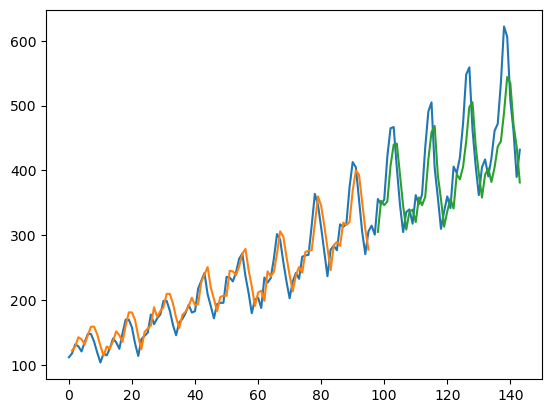

In [9]:
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
print('Train Score: %.2f RMSE' % trainScore)
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print('Test Score: %.2f RMSE' % testScore)

# shift train predictions for plotting
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict

# shift test predictions for plotting
testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(dataset)-1, :] = testPredict

# plot baseline and predictions
plt.plot(scaler.inverse_transform(dataset))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()